In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [14]:
# read in the data
df_train = pd.read_csv('../input/train_users_2.csv')
df_test = pd.read_csv('../input/test_users.csv')
sessions = pd.read_csv('../input/sessions.csv')

## Preliminary examination of the data

The training data consists of 213,451 rows x 16 columns while the test data has 62,096 rows x 15 columns with our target feature 'country_destination' being the additional column in the training set. We can immediately see that we have a substantial number of missing values for age.

In [3]:
# training data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 27.7+ MB


In [4]:
# test data
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62096 entries, 0 to 62095
Data columns (total 15 columns):
id                         62096 non-null object
date_account_created       62096 non-null object
timestamp_first_active     62096 non-null int64
date_first_booking         0 non-null float64
gender                     62096 non-null object
age                        33220 non-null float64
signup_method              62096 non-null object
signup_flow                62096 non-null int64
language                   62096 non-null object
affiliate_channel          62096 non-null object
affiliate_provider         62096 non-null object
first_affiliate_tracked    62076 non-null object
signup_app                 62096 non-null object
first_device_type          62096 non-null object
first_browser              62096 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 7.6+ MB


## Cleaning age data

The age data is a bit messy - there are many values in the order of thousands. We will try to make some reasonable assumptions and use this to clean it up. We establish a valid range of ages as (14, 100) and assume that any values between 1919 and 1995 are birth years. Any ages outside the valid range are set to NaN.

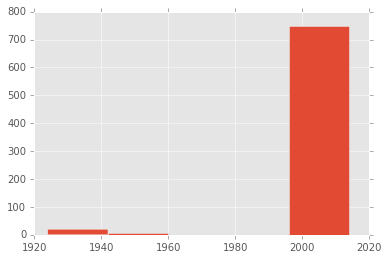

In [5]:
df_train[df_train.age > 1000].age.hist(bins=5)

In [37]:
av = df_train.age.values
df_train['age'] = np.where(np.logical_and(av>1919, av<1995), 2015-av, av)
df_train['age'] = np.where(np.logical_or(av<14, av>100), np.nan, av)

The age data also has a significant number of missing values. The plots below show the country destination proportions for users who have provided their age and for those where age is missing. Only 25% users with missing ages book while 55% of users with age provided book. This suggests there is value to identifying users who have not provided age if, for example, we decide to impute missing ages. It could be that taking the step of providing age is a sign a user is more serious about making a booking. 

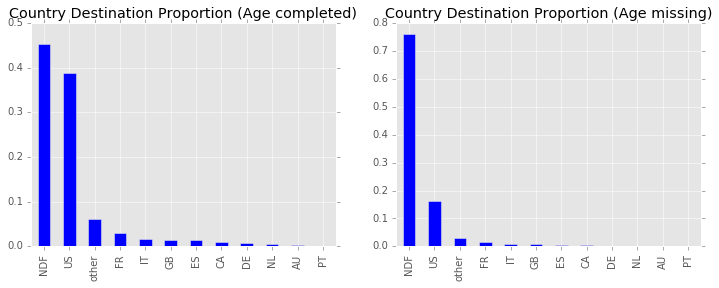

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
complete_age = df_train[df_train.age.notnull()].country_destination.value_counts()
missing_age = df_train[df_train.age.isnull()].country_destination.value_counts()
complete_age.div(complete_age.sum()).plot(kind='bar',title='Country Destination Proportion (Age completed)',ax=axes[0])
missing_age.div(missing_age.sum()).plot(kind='bar',title='Country Destination Proportion (Age missing)',ax=axes[1])

## Data Exploration
We begin by looking at the frequency of each class of our target feature, Country Destination. We know from the competition description that there should be 12 classes.

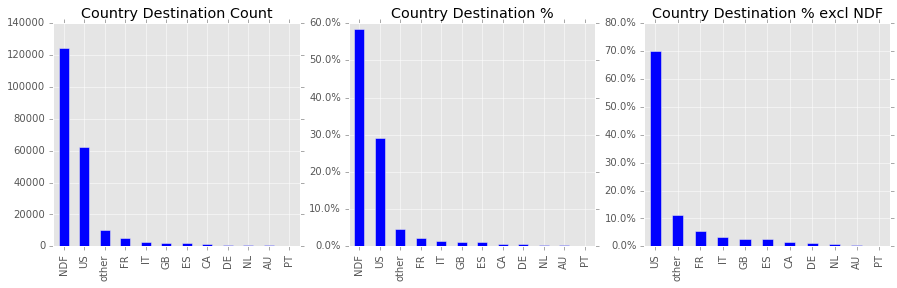

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 4))
country_counts = df_train.country_destination.value_counts()
country_counts.plot(kind='bar',title='Country Destination Count',ax=axes[0])
ax = country_counts.div(country_counts.sum()).plot(kind='bar',title='Country Destination %',ax=axes[1] )
ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax.get_yticks()])
booked_count = df_train[df_train.country_destination != 'NDF'].country_destination.value_counts()
ax1 = booked_count.div(booked_count.sum()).plot(kind='bar',title='Country Destination % excl NDF',ax=axes[2] )
ax1.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax1.get_yticks()])

All 12 classes are represented in the training data and we can see that nearly 60% of users do not make a booking. Of the users that do book, about 70% do so in the US. We have rather imbalanced classes and will need to keep this in mind when training our model. 

We are also provided a file that gives us summary statistics for users who made a booking in 2015. We are not provided a count of users who did not book nor a count for users who booked a country in the 'other' category. However, this is still useful to see if the distribution of bookings for the remaining countries is stable through time.

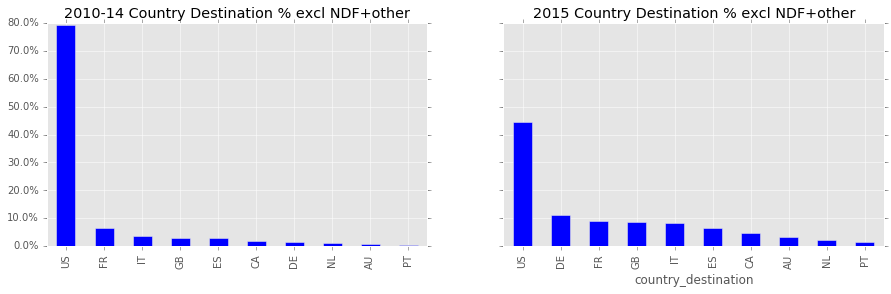

In [31]:
fig, axes1 = plt.subplots(nrows=1, ncols=2,figsize=(15, 4), sharey=True)
actual_cntry = booked_count.drop('other')
ax2 = actual_cntry.div(actual_cntry.sum()).plot(kind='bar',title='2010-14 Country Destination % excl NDF+other',ax=axes1[0] )
ax2.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax2.get_yticks()])
age_gender_bkts = pd.read_csv("../input/age_gender_bkts.csv")
country_dest = age_gender_bkts.groupby(['country_destination'])['population_in_thousands'].sum().reset_index()
country_dest.set_index('country_destination', inplace=True)
country_dest.sort_values(by='population_in_thousands',ascending=False,inplace=True)
ax3 = country_dest['population_in_thousands'].div(country_dest['population_in_thousands'].sum()).plot(kind='bar',title='2015 Country Destination % excl NDF+other')
ax3.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax3.get_yticks()])

The plots above show that the distribution of bookings changed fairly dramatically. The percentage of bookings in non-US countries increased substantially while that of the US declined. Since we are training our model in pre Jul-14 data in order to predict post Jul-14 behavior, it may be useful to oversample non-US countries in our training data to better match the new distribution of country destinatiions. There is, of course, the risk that user behavior in the 2nd half of 2014 is not the same as 2015 user behavior.

### Age

(10, 60)

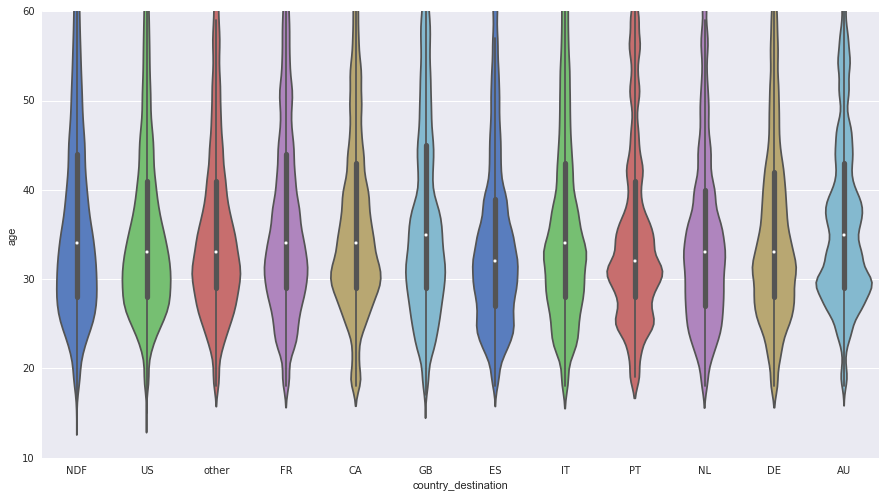

In [128]:
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.violinplot(x='country_destination', y='age', data=df_train, palette="muted", ax =ax, bw=.1)
ax.set_ylim([10, 60])

### Categorical variables

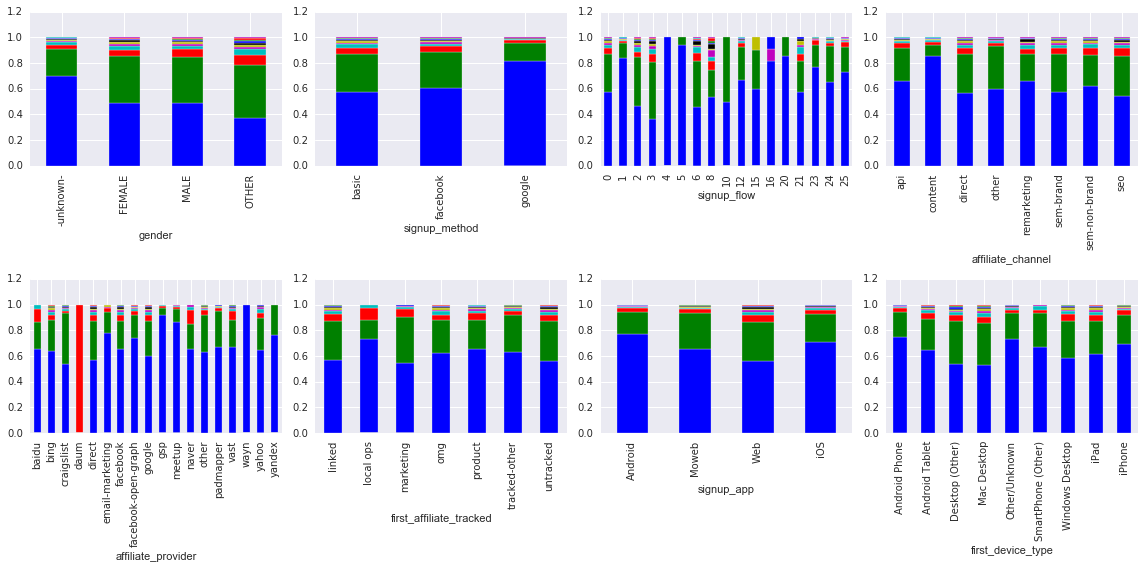

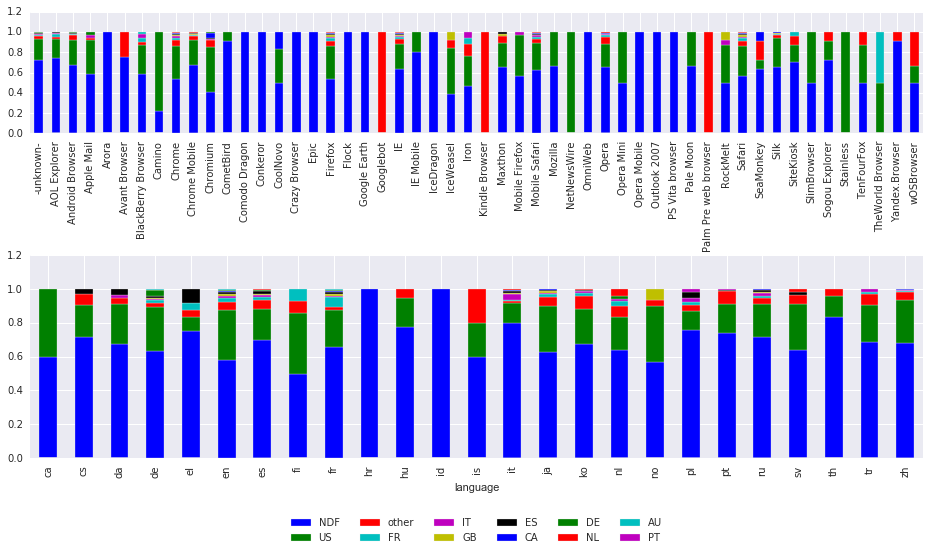

In [149]:
fig, (ax4,ax5) = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
bar_order = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']
gender = pd.crosstab([df_train.gender], df_train.country_destination).apply(lambda x: x/x.sum(), axis=1)
gender[bar_order].plot(kind='bar', stacked=True, ax=ax4[0],legend=False)
signup_method = pd.crosstab([df_train.signup_method], df_train.country_destination).apply(lambda x: x/x.sum(), axis=1)
signup_method[bar_order].plot(kind='bar', stacked=True, ax=ax4[1], legend=False)
signup_flow = pd.crosstab([df_train.signup_flow], df_train.country_destination).apply(lambda x: x/x.sum(), axis=1)
signup_flow[bar_order].plot(kind='bar', stacked=True, ax=ax4[2], legend=False)
affiliate_channel = pd.crosstab([df_train.affiliate_channel], df_train.country_destination).apply(lambda x: x/x.sum(), axis=1)
affiliate_channel[bar_order].plot(kind='bar', stacked=True, ax=ax4[3], legend=False)
affiliate_provider = pd.crosstab([df_train.affiliate_provider], df_train.country_destination).apply(lambda x: x/x.sum(), axis=1)
affiliate_provider[bar_order].plot(kind='bar', stacked=True, ax=ax5[0], legend=False)
first_affiliate_tracked = pd.crosstab([df_train.first_affiliate_tracked], df_train.country_destination).apply(lambda x: x/x.sum(), axis=1)
first_affiliate_tracked[bar_order].plot(kind='bar', stacked=True, ax=ax5[1], legend=False)
signup_app = pd.crosstab([df_train.signup_app], df_train.country_destination).apply(lambda x: x/x.sum(), axis=1)
signup_app[bar_order].plot(kind='bar', stacked=True, ax=ax5[2], legend=False)
first_device_type = pd.crosstab([df_train.first_device_type], df_train.country_destination).apply(lambda x: x/x.sum(), axis=1)
first_device_type[bar_order].plot(kind='bar', stacked=True, ax=ax5[3], legend=False)
plt.tight_layout()
fig, ax6 = plt.subplots(nrows=2, ncols=1, figsize=(16, 8), sharey=True)
first_browser = pd.crosstab([df_train.first_browser], df_train.country_destination).apply(lambda x: x/x.sum(), axis=1)
first_browser[bar_order].plot(kind='bar', stacked=True, ax=ax6[0], legend=False)
box = ax6[0].get_position()
ax6[0].set_position([box.x0, box.y0 + box.height * 0.4, box.width, box.height * 0.6])
language = pd.crosstab([df_train.language], df_train.country_destination).apply(lambda x: x/x.sum(), axis=1)
language[bar_order].plot(kind='bar', stacked=True, ax=ax6[1], legend=True)
ax6[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=6)

### Dates

In [77]:
df_train['date_account_created'] = pd.to_datetime(df_train['date_account_created'])
df_train['date_first_active'] = pd.to_datetime((df_train.timestamp_first_active // 1000000), format='%Y%m%d')
df_train['date_first_booking'] = pd.to_datetime(df_train['date_first_booking'])
time_btw_dac_dfb = df_train['date_first_booking'] - df_train['date_account_created']
time_btw_tfa_dfb = df_train['date_first_booking'] - df_train['date_first_active']
print '---Time between Date Account Created and First Booking---'
print time_btw_dac_dfb.describe()
print '---Time between Date First Active and First Booking---'
print time_btw_tfa_dfb.describe()

---Time between Date Account Created and First Booking---
count                      88908
mean     44 days 08:41:59.854231
std      87 days 11:59:22.090141
min          -349 days +00:00:00
25%              1 days 00:00:00
50%              3 days 00:00:00
75%             29 days 00:00:00
max            365 days 00:00:00
dtype: object
---Time between Date First Active and First Booking---
count                      88908
mean     44 days 16:36:44.022135
std      88 days 11:35:12.574019
min              0 days 00:00:00
25%              1 days 00:00:00
50%              3 days 00:00:00
75%             29 days 00:00:00
max           1369 days 00:00:00
dtype: object


After cleaning up the 3 date variables, we can take a look at the distribution of time between 1) 'Date Account Created' 2) 'Date First Active' and 'Date First Booking.' We can see both average 44 days but have a very skewed distribution. 50% of people take 3 days and 75% take 29 with the average pulled up by a few very large outliers.

We next take a look at a plot of the count of 'Date First Booking' over time. Note the 3 US summer holidays (Memorial Day, Independence Day, Labor Day) are marked with a 'O' each year.

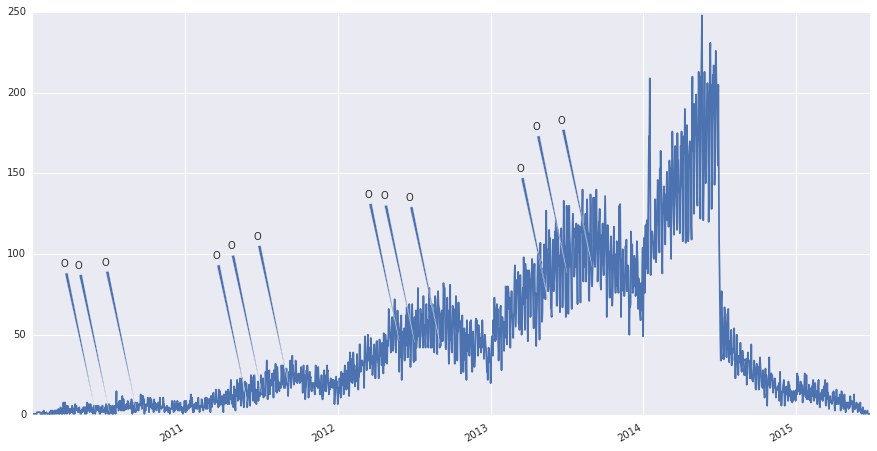

In [81]:
import holidays
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
df_train['date_first_booking'].value_counts().plot(kind='line', ax=axes)
holidays_tuples = holidays.US(years=[2010,2011,2012,2013])
popular_holidays = ['Independence Day', 'Labor Day', 'Memorial Day']
holidays_tuples = {k:v for (k,v) in holidays_tuples.items() if v in popular_holidays}
us_holidays = pd.to_datetime([i[0] for i in np.array(holidays_tuples.items())])
for date in us_holidays:
    axes.annotate('O', (date, df_train[df_train.date_first_booking == date]['date_first_booking'].value_counts()), xytext=(-35, 145), 
                textcoords='offset points', arrowprops=dict(arrowstyle='wedge'))
fig.autofmt_xdate()
plt.show()

What immediately stands out is the seasonality of bookings. Bookings reach a peak around Labor Day each year and then decline into year end before starting to pick up again after New Year's. This suggests the month in the date variables could be useful to separate. Additionally, there appear to be small spikes in bookings right around the summer holidays so perhaps this could be useful, as well. (The spike in early 2014 is possibly the Super Bowl).

## Sessions data

### Total Secs Elapsed

In [82]:
id_all = df_train['id']
sessions_rel = sessions[sessions.user_id.isin(id_all)]
grp_by_sec_elapsed = sessions_rel.groupby(['user_id'])['secs_elapsed'].sum().reset_index()
grp_by_sec_elapsed.columns = ['user_id', 'secs_elapsed']
temp1 = pd.merge(df_train, grp_by_sec_elapsed, how='inner', left_on='id', right_on='user_id')

(-1000000, 5000000)

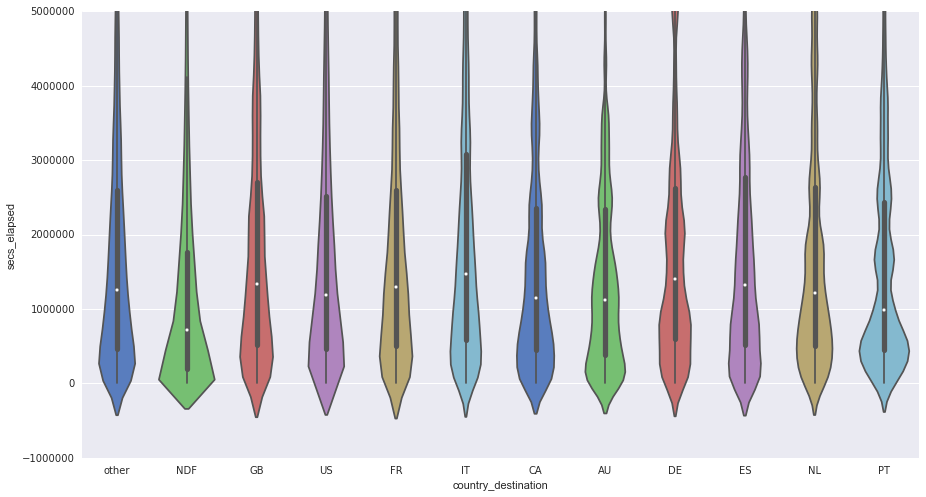

In [127]:
fig, ax7 = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
vp1 = sns.violinplot(x='country_destination', y='secs_elapsed', data=temp1, palette='muted', ax= ax7, bw=.1)
ax7.set_ylim([-1000000, 5000000])

### Aggregating by action and counting action details

In [98]:
ct_action_detailXaction = pd.pivot_table(sessions_rel, index = ['user_id'],
                        columns = ['action'],
                        values = 'action_detail',
                        aggfunc=len, fill_value=0).reset_index()
ct_action_detailXaction.rename(
    columns = lambda x: x if (x == 'user_id') else x + "_action_detail_ct", 
    inplace = True)
temp2 = pd.merge(df_train, ct_action_detailXaction, how='inner', left_on='id', right_on='user_id')

(-4, 15)

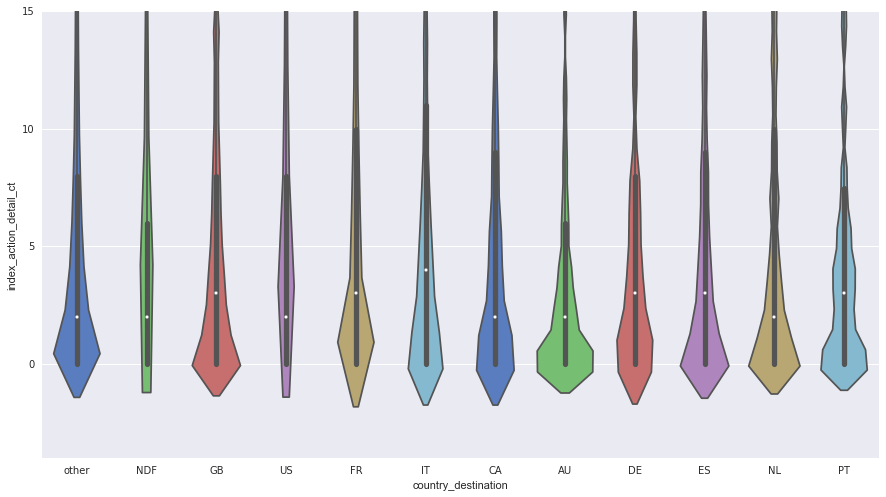

In [124]:
fig, ax8 = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.violinplot(x='country_destination', y='index_action_detail_ct', data=temp2, palette='muted', ax=ax8, bw=.05)
ax8.set_ylim([-4, 15])